In [ ]:
from fastai.vision import *

## Data

In [ ]:
path = Config().data_path()/'imagenet'

### Inputs: precomputed activations

We will build a model on the whole of ImageNet, so we will compute once and for all the activations for the whole training and validation set. We use `presize` to set the images to 224 x 224 by jsut using PIL.

In [ ]:
src = (ImageList.from_folder(path)
          .split_by_folder()
          .label_from_folder())

In [ ]:
data = src.presize(size=224).databunch(bs=256).normalize(imagenet_stats)

This is the pretrained resnet50 with concat pool and flatten:

In [ ]:
body = create_body(models.resnet50)
layers = list(body.children())
layers += [AdaptiveConcatPool2d(), Flatten()]   
body = nn.Sequential(*layers).to(defaults.device)

We will use bcolz to store our activations in an array that's saved to memory (all won't fit in RAM). Install with 
```
pip install -U bcolz
```

In [ ]:
import bcolz

In [ ]:
tmp_path = path/'tmp'

In [ ]:
#To clean-up previous tries
#shutil.rmtree(tmp_path)

Those functions will store the precomputed activations in `tmp_path`.

In [ ]:
def precompute_activations_dl(dl, model, path:Path, force:bool=False):
    body.eval()
    if os.path.exists(path) and not force: return
    arr = bcolz.carray(np.zeros((0,4096), np.float32), chunklen=1, mode='w', rootdir=path)
    with torch.no_grad():
        for x,y in progress_bar(dl):
            z = body(x)
            arr.append(z.cpu().numpy())
            arr.flush()

In [ ]:
def precompute_activations(data, model, path:Path, force:bool=False):
    os.makedirs(path, exist_ok=True)
    precompute_activations_dl(data.fix_dl,   model, path/'train', force=force) #Use fix_dl and not train_dl for shuffle=False
    precompute_activations_dl(data.valid_dl, model, path/'valid', force=force)

In [ ]:
precompute_activations(data, body, tmp_path)

Save the labels and the filenames in the same order as our activations.

In [ ]:
np.save(tmp_path/'trn_lbl.npy', data.train_ds.y.items)
np.save(tmp_path/'val_lbl.npy', data.valid_ds.y.items)
save_texts(tmp_path/'classes.txt', data.train_ds.classes)

In [ ]:
np.save(tmp_path/'trn_names.npy', data.train_ds.x.items)
np.save(tmp_path/'val_names.npy', data.valid_ds.x.items)

To load our precomputed activations, we'll use the following `ItemList`

In [ ]:
class BcolzItemList(ItemList):
    def __init__(self, path, **kwargs):
        self.arr = bcolz.open(path)
        super().__init__(range(len(self.arr)), **kwargs)
    
    def get(self, i): return self.arr[i]

In [ ]:
src = ItemLists(path, BcolzItemList(path/'tmp'/'train'), BcolzItemList(path/'tmp'/'valid'))

### Targets: word vectors

We build a regression model that has to predict a vector from the image features. We need to associate a word vector to each one of our 1000 classes.

In [ ]:
classes = loadtxt_str(tmp_path/'classes.txt')

In [ ]:
classes, len(classes)

(array(['n01440764', 'n01443537', 'n01484850', 'n01491361', ..., 'n13052670', 'n13054560', 'n13133613', 'n15075141'],
       dtype='<U9'), 1000)

The labels in imagenet are codes that come from [wordnet](https://wordnet.princeton.edu/). So let's download the corresponding dictionary.

In [ ]:
WORDNET = 'classids.txt'
download_url(f'http://files.fast.ai/data/{WORDNET}', path/'tmp'/WORDNET)

In [ ]:
class_ids = loadtxt_str(path/'tmp'/WORDNET)
class_ids = dict([l.strip().split() for l in class_ids])

In [ ]:
named_classes = [class_ids[c] for c in classes]
named_classes[:10]

['tench',
 'goldfish',
 'great_white_shark',
 'tiger_shark',
 'hammerhead',
 'electric_ray',
 'stingray',
 'cock',
 'hen',
 'ostrich']

We will train our model to predict not the label of its class, but the corresponding pretrained vector. There are plenty of word embeddings available, here we will use fastText.

To install fastText:
```
$ git clone https://github.com/facebookresearch/fastText.git
$ cd fastText
$ pip install .
```

To download the english embeddings:

```
$ wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
```

In [ ]:
import fastText as ft
en_vecs = ft.load_model(str((path/'cc.en.300.bin')))

A lot of our classes are actually composed of several words separated by a `_`. The pretrained word vectors from fastText won't know them directly, but it can still compute a word vector to represent them:

In [ ]:
vec_dog = en_vecs.get_sentence_vector('dog')
vec_lab = en_vecs.get_sentence_vector('labrador')
vec_gor = en_vecs.get_sentence_vector('golden retriever')
vec_ban = en_vecs.get_sentence_vector('banana')

To check if two word vectors are close or not, we use cosine similarity.

In [ ]:
F.cosine_similarity(tensor(vec_dog[None]), tensor(vec_lab[None]))

tensor([0.6715])

In [ ]:
F.cosine_similarity(tensor(vec_dog[None]), tensor(vec_ban[None]))

tensor([0.1956])

In [ ]:
F.cosine_similarity(tensor(vec_lab[None]), tensor(vec_ban[None]))

tensor([0.2677])

In [ ]:
F.cosine_similarity(tensor(vec_dog[None]), tensor(vec_gor[None]))

tensor([0.4356])

In [ ]:
F.cosine_similarity(tensor(vec_lab[None]), tensor(vec_gor[None]))

tensor([0.5824])

So let's grab all the word vectors for all our classes:

In [ ]:
vecs = []
for n in named_classes:
    vecs.append(en_vecs.get_sentence_vector(n.replace('_', ' ')))

Then we label each feature map with the word vector of its target.

In [ ]:
train_labels = np.load(tmp_path/'trn_lbl.npy')
valid_labels = np.load(tmp_path/'val_lbl.npy')
train_vecs = [vecs[l] for l in train_labels]
valid_vecs = [vecs[l] for l in valid_labels]

We use our custom `BcolzItemList` to gather the data:

In [ ]:
src = ItemLists(path, BcolzItemList(tmp_path/'train'), BcolzItemList(tmp_path/'valid'))
src = src.label_from_lists(train_vecs, valid_vecs, label_cls=FloatList)

In [ ]:
data = src.databunch(bs=512, num_workers=16)

In [ ]:
model = create_head(4096, data1.c, lin_ftrs = [1024], ps=[0.2,0.2])
model = nn.Sequential(*list(model.children())[2:])

In [ ]:
def cos_loss(inp,targ): return 1 - F.cosine_similarity(inp,targ).mean()

In [ ]:
learn = Learner(data, model, loss_func=cos_loss)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


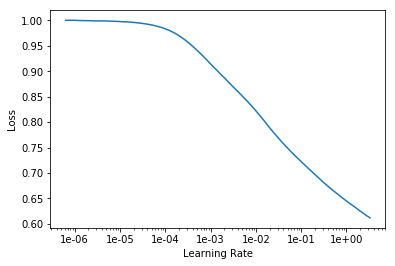

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(15,3e-2)

In [ ]:
learn.save('fit')

In [ ]:
learn.model.eval()
preds = []
with torch.no_grad():
    for x,y in progress_bar(learn1.data.fix_dl):
        preds.append(learn1.model(x).cpu().numpy())
    for x,y in progress_bar(learn1.data.valid_dl):
        preds.append(learn1.model(x).cpu().numpy())

In [ ]:
preds = np.concatenate(preds, 0)

In [ ]:
np.save(path/'preds.npy', preds)

### Looking at predicted tags in image classes

Now we will check, for one given image, what are the word vectors that are the closes to it. To compute this very quickly, we use `nmslib` which is very fast (pip install nmslib).

In [ ]:
import nmslib

def create_index(a):
    index = nmslib.init(space='angulardist')
    index.addDataPointBatch(a)
    index.createIndex()
    return index

def get_knns(index, vecs):
     return zip(*index.knnQueryBatch(vecs, k=10, num_threads=4))

def get_knn(index, vec): return index.knnQuery(vec, k=10)

We first look in the word vectors of our given classes:

In [ ]:
nn_classes = create_index(vecs)

In [ ]:
valid_preds = preds[-len(data.valid_ds):]
valid_names = np.load(tmp_path/'val_names.npy')

In [ ]:
idxs,dists = get_knns(nn_classes, valid_preds)

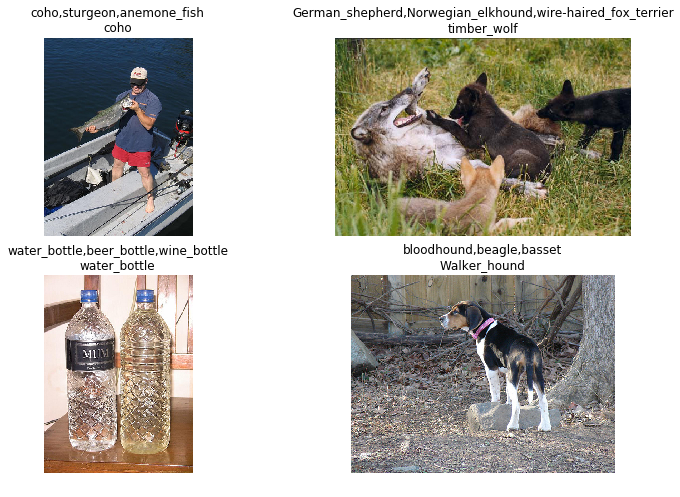

In [ ]:
ks = [0,10000,20000,30000]
_,axs = plt.subplots(2,2,figsize=(12,8))
for k,ax in zip(ks, axs.flatten()):
    open_image(valid_names[k]).show(ax = ax)
    title = ','.join([class_ids[classes[i]] for i in idxs[k][:3]])
    title += f'\n{class_ids[classes[valid_labels[k]]]}'
    ax.set_title(title)

### Looking at predicted tags in all Wordnet

Now let's look at the words it finds in all Wordnet.

In [ ]:
words,wn_vecs = [],[]
for k,n in class_ids.items():
    words.append(n)
    wn_vecs.append(en_vecs.get_sentence_vector(n.replace('_', ' ')))

In [ ]:
nn_wvs = create_index(wn_vecs)

In [ ]:
idxs,dists = get_knns(nn_wvs, valid_preds)

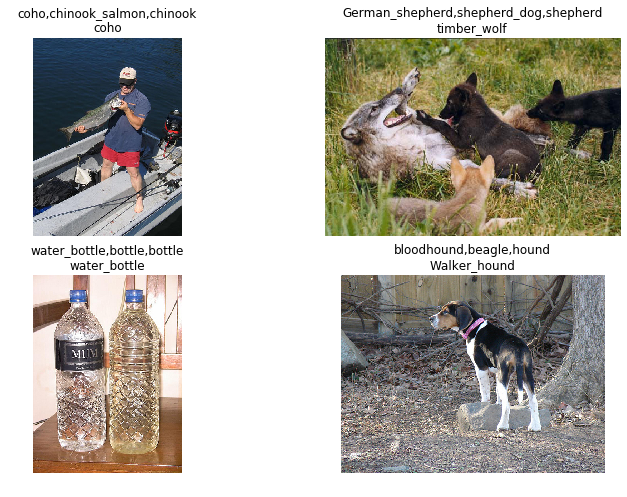

In [ ]:
ks = [0,10000,20000,30000]
_,axs = plt.subplots(2,2,figsize=(12,8))
for k,ax in zip(ks, axs.flatten()):
    open_image(valid_names[k]).show(ax = ax)
    title = ','.join([words[i] for i in idxs[k][:3]])
    title += f'\n{class_ids[classes[valid_labels[k]]]}'
    ax.set_title(title)

### Text -> Image search

We can use the reverse approach: feed a word vector and find the image activations that match it the closest:

In [ ]:
nn_preds = create_index(valid_preds)

In [ ]:
def show_imgs_from_text(text):
    vec = en_vecs.get_sentence_vector(text)
    idxs,dists = get_knn(nn_preds, vec)
    _,axs = plt.subplots(2,2,figsize=(12,8))
    for i,ax in zip(idxs[:4], axs.flatten()):
        open_image(valid_names[i]).show(ax = ax)

'boat' isn't a label in ImageNet, yet if we ask the images whose vord vectors are the most similar to the word vector for boat...

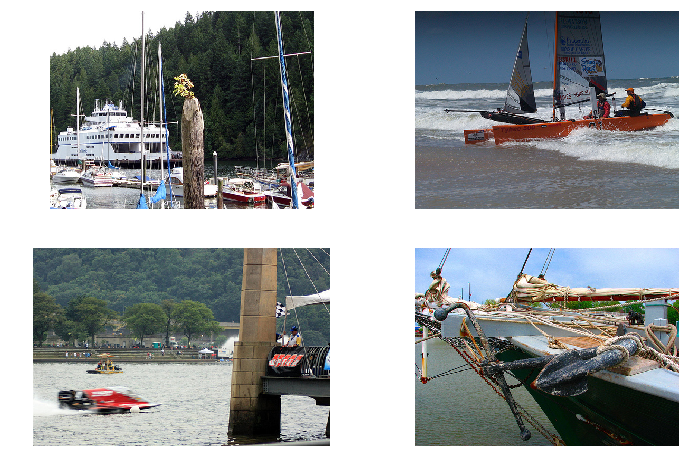

In [ ]:
show_imgs_from_text('boat')

or even more precisely 'motor boat'

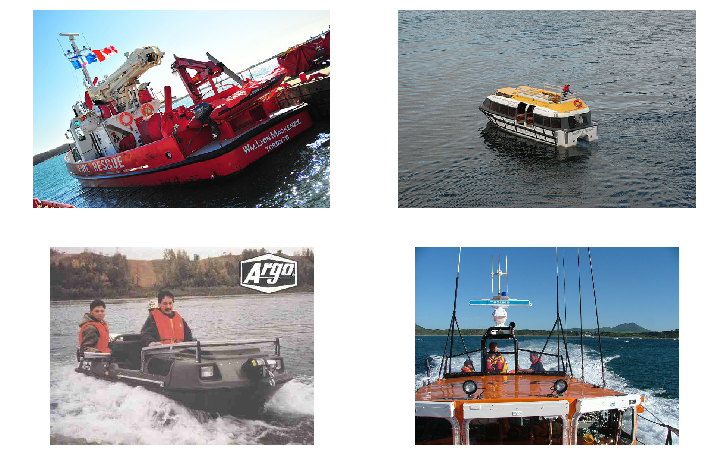

In [ ]:
show_imgs_from_text('motor boat')

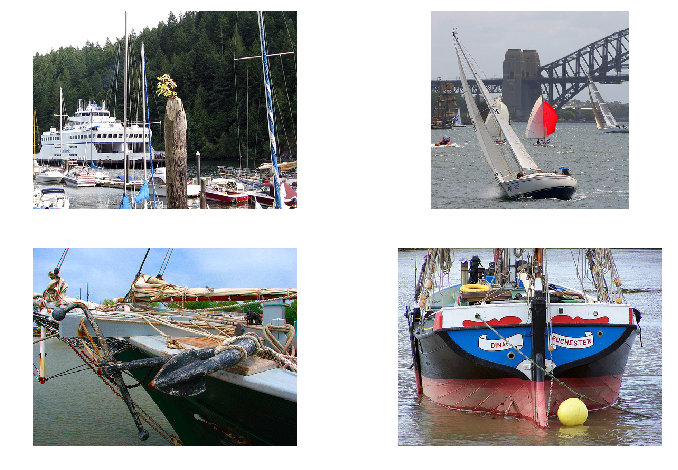

In [ ]:
show_imgs_from_text('sail boat')

### Image->image

We can also ask for the images with a word vector most similar to another image. This one was downloaded from Google and isn't in Imagenet.

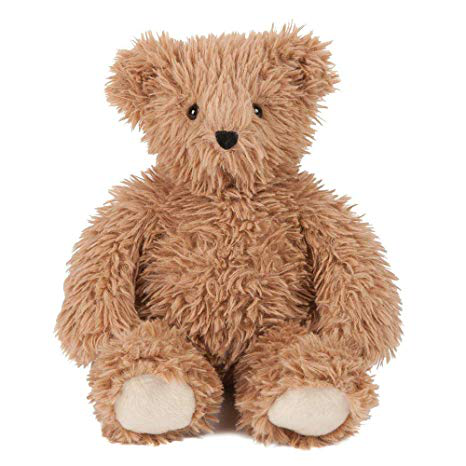

In [ ]:
img = open_image('images/teddy_bear.jpg')
img

To get the corresdponding vector, we need to feed it to the pretrained model (`body`, defined at the top) after normalizing it.

In [ ]:
img = img.data
m,s = imagenet_stats
x = (img - tensor(m)[:,None,None])/tensor(s)[:,None,None]

In [ ]:
activs = body.eval()(x[None].cuda())

In [ ]:
pred = learn.model.eval()(activs)

In [ ]:
pred = pred[0].detach().cpu().numpy()

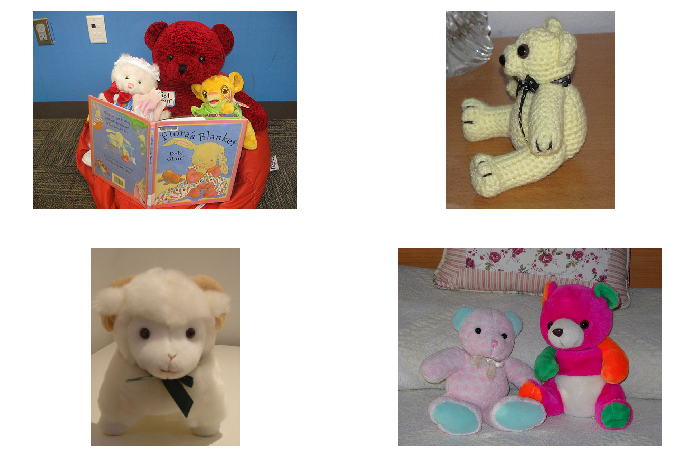

In [ ]:
idxs,dists = get_knn(nn_preds, pred)
_,axs = plt.subplots(2,2,figsize=(12,8))
for i,ax in zip(idxs[:4], axs.flatten()):
    open_image(valid_names[i]).show(ax = ax)